In [1]:
%matplotlib inline
import zipfile
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import grid_search
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier

/Users/pedrobuzzi/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/pedrobuzzi/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
zf = zipfile.ZipFile('./data/train_users_2.csv.zip')
df_train = pd.read_csv(zf.open('train_users_2.csv'))

zf = zipfile.ZipFile('./data/test_users.csv.zip')
df_test = pd.read_csv(zf.open('test_users.csv'))

In [3]:
zf = zipfile.ZipFile('./data/sessions.csv.zip')
df_session = pd.read_csv(zf.open('sessions.csv'))

In [4]:
zf = zipfile.ZipFile('./data/age_gender_bkts.csv.zip')
df_age_gender = pd.read_csv(zf.open('age_gender_bkts.csv'))

In [5]:
# zf = zipfile.ZipFile('./data/countries.csv.zip')
# df_countries = pd11.read_csv(zf.open('countries.csv'))

## Exploração dos dados


##### Juntar dados de treinamento e teste.

In [7]:
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

#### Dispositivo do primeiro acesso

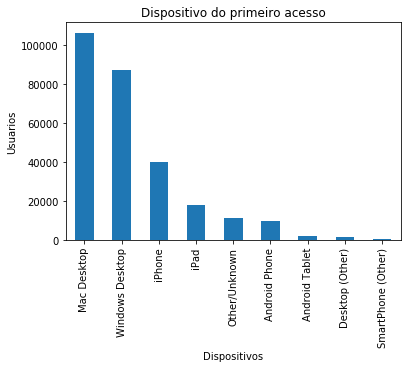

In [354]:
df_all.groupby('first_device_type').size().sort_values(ascending=False).plot(kind='bar')
plt.title('Dispositivo do primeiro acesso')
plt.xlabel('Dispositivos')
plt.ylabel('Usuarios')

#### Forma de acesso

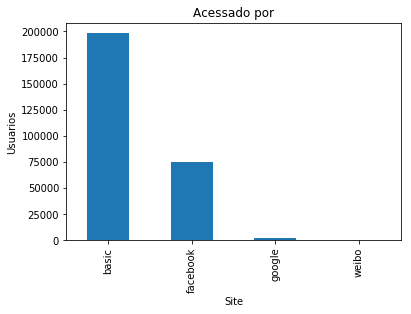

In [355]:
df_all.signup_method.value_counts().plot(kind='bar')
plt.title('Acessado por')
plt.xlabel('Site')
plt.ylabel('Usuarios')

#### Quem forneceu o acesso

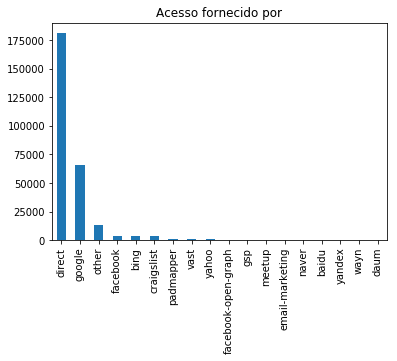

In [350]:
df_all.affiliate_provider.value_counts().plot(kind='bar')
plt.title('Acesso fornecido por')

#### Genêros em porcentagem

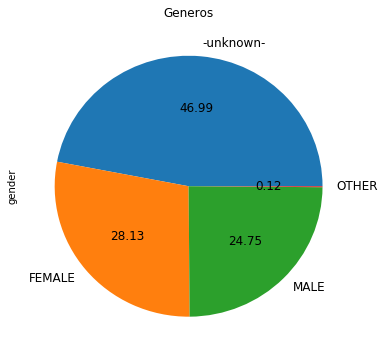

In [349]:
df_all.gender.value_counts().plot.pie(autopct='%.2f', fontsize=12, figsize=(6, 6))
plt.title('Generos')

#### Dispositivo da reserva

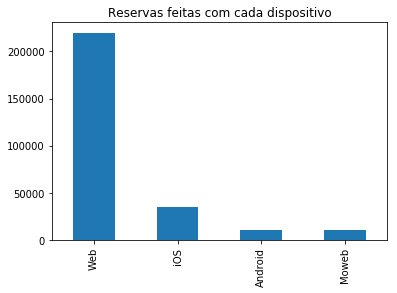

In [13]:
df_all.signup_app.value_counts().plot(kind='bar')
plt.title('Reservas feitas com cada dispositivo')

#### Idades inferiores a 18 e superiores a 1900

In [16]:
df_all[df_all.age < 18]['age'].describe()

count    188.000000
mean      12.718085
std        5.764569
min        1.000000
25%        5.000000
50%       16.000000
75%       17.000000
max       17.000000
Name: age, dtype: float64

In [19]:
df_all.loc[(df_all.age > 100) & (df_all.age < 1900)]['age'].describe()

count    1862.000000
mean      105.683136
std         2.461640
min       101.000000
25%       105.000000
50%       105.000000
75%       105.000000
max       150.000000
Name: age, dtype: float64

#### Porcentagem de reserva em cada país

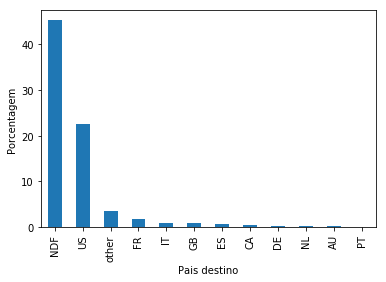

In [21]:
destination_percentage = df_all.country_destination.value_counts() / df_all.shape[0] * 100
destination_percentage.plot(kind='bar')
plt.xlabel('Pais destino')
plt.ylabel('Porcentagem')

#### Idioma faltando '-unknown-'

In [8]:
df_all.language.unique()

array(['en', 'fr', 'de', 'es', 'it', 'pt', 'zh', 'ko', 'ja', 'ru', 'pl',
       'el', 'sv', 'nl', 'hu', 'da', 'id', 'fi', 'no', 'tr', 'th', 'cs',
       'hr', 'ca', 'is', '-unknown-'], dtype=object)

#### Gênero faltando '-unknown-'

In [11]:
df_all.gender.unique()

array(['-unknown-', 'MALE', 'FEMALE', 'OTHER'], dtype=object)

## Preparação dos dados

In [252]:
df_all.columns

Index([u'affiliate_channel', u'affiliate_provider', u'age',
       u'country_destination', u'date_account_created', u'date_first_booking',
       u'first_affiliate_tracked', u'first_browser', u'first_device_type',
       u'gender', u'id', u'language', u'signup_app', u'signup_flow',
       u'signup_method', u'timestamp_first_active'],
      dtype='object')

array(['en', 'fr', 'de', 'es', 'it', 'pt', 'zh', 'ko', 'ja', 'ru', 'pl',
       'el', 'sv', 'nl', 'hu', 'da', 'id', 'fi', 'no', 'tr', 'th', 'cs',
       'hr', 'ca', 'is', '-unknown-'], dtype=object)

In [9]:
# Gênero faltando
df_all.gender.unique()

array(['-unknown-', 'MALE', 'FEMALE', 'OTHER'], dtype=object)

In [10]:
df_all[df_all.gender == 'MISSING_GENDER'].shape[0]

0

### Tratamento de Idiomas

##### Substituindo gêneros "-unknown-" por "MISSING_LANGUAGE"

In [256]:
def languages(df):
    df.language.replace('-unknown-', 'MISSING_LANGUAGE', inplace=True)
    return df

In [257]:
df_all = languages(df_all)

### Tratamento de Gêneros

##### Substituindo gêneros "-unknown-" por "MISSING_GENDER"

In [258]:
def gender(df):
    df.gender.replace('-unknown-', 'MISSING_GENDER', inplace=True)
    return df

In [259]:
df_all = gender(df_all)

### Tratamento de Idades

##### Calculando idades preenchidas incorretamente. Onde foi preenchido o ano de nascimento ao invés da idade.

In [260]:
def age_calculate(df):
    user_with_year_age_mask = df['age'] > 1000
    
    # 2015 é o ano que os dados foram extraídos
    df.loc[user_with_year_age_mask, 'age'] = 2015 - df.loc[user_with_year_age_mask, 'age']
    return df    

In [261]:
df_all = age_calculate(df_all)

##### Removendo idades superiores a 100 e inferiores a 18 anos

In [262]:
def age_remove_invalids(df):
    df.loc[(df_all['age'] > 100) | (df['age'] < 18), 'age'] = -1
    df['age'].fillna(-1, inplace=True)
    return df

In [263]:
df_all = age_remove_invalids(df_all)

##### Dividindo por faixas de idade

In [264]:
def age_grouping(df):
    bins = [-1, 21, 25, 30, 35, 40, 50, 60, 75, 100]
    df['age_group'] = np.digitize(df['age'], bins, right=True)
    return df

In [265]:
df_all = age_grouping(df_all)

### Apagando colunas

In [266]:
def remove_columns(df):
    drop_features = [
        'age',
        'date_account_created',
        'date_first_booking',
        'timestamp_first_active',
        'affiliate_provider',
        'affiliate_channel',
        'first_affiliate_tracked',
        'first_browser'
    ]
    df.drop(drop_features, axis=1, inplace=True)
    return df

In [267]:
df_all = remove_columns(df_all)

### One Hot Encoding

In [268]:
def one_hot_encoding(df):
    categoricals = ['first_device_type', 'gender', 'signup_method', 'signup_flow', 'language', 'signup_app']
    df = pd.get_dummies(df, columns=categoricals, prefix='is')
    return df

In [269]:
df_all = one_hot_encoding(df_all)

### Adicionando colunas

In [270]:
def session_features(df, df_session):
    bigger_session = df_session.groupby('user_id')['secs_elapsed'].max()
    distinct_sessions = df_session.groupby('user_id')['action'].nunique()
    num_devices = df_session.groupby('user_id')['device_type'].nunique()
    total_seconds = df_session.groupby('user_id')['secs_elapsed'].sum()
    df['total_seconds'] = df['id'].apply(lambda x: total_seconds[x] if x in total_seconds else 0)
    df['num_devices'] = df['id'].apply(lambda x: num_devices[x] if x in num_devices else 0)
    df['distinct_sessions'] = df['id'].apply(lambda x: distinct_sessions[x] if x in distinct_sessions else 0)
    df['bigger_session'] = df['id'].apply(lambda x: bigger_session[x] if x in bigger_session else 0)
    return df

In [271]:
df_all.columns

Index([u'country_destination', u'id', u'age_group', u'is_Android Phone',
       u'is_Android Tablet', u'is_Desktop (Other)', u'is_Mac Desktop',
       u'is_Other/Unknown', u'is_SmartPhone (Other)', u'is_Windows Desktop',
       u'is_iPad', u'is_iPhone', u'is_FEMALE', u'is_MALE',
       u'is_MISSING_GENDER', u'is_OTHER', u'is_basic', u'is_facebook',
       u'is_google', u'is_weibo', u'is_0', u'is_1', u'is_2', u'is_3', u'is_4',
       u'is_5', u'is_6', u'is_8', u'is_10', u'is_12', u'is_14', u'is_15',
       u'is_16', u'is_20', u'is_21', u'is_23', u'is_24', u'is_25',
       u'is_MISSING_LANGUAGE', u'is_ca', u'is_cs', u'is_da', u'is_de',
       u'is_el', u'is_en', u'is_es', u'is_fi', u'is_fr', u'is_hr', u'is_hu',
       u'is_id', u'is_is', u'is_it', u'is_ja', u'is_ko', u'is_nl', u'is_no',
       u'is_pl', u'is_pt', u'is_ru', u'is_sv', u'is_th', u'is_tr', u'is_zh',
       u'is_Android', u'is_Moweb', u'is_Web', u'is_iOS'],
      dtype='object')

### BACKUP df_all

In [274]:
df_all_bkp = df_all.copy()

##### Separa os dados de teste e de treinamento

In [279]:
df_all.set_index('id', inplace=True)
train_processed = df_all.loc[df_train['id']]
test_processed = df_all.loc[df_test['id']]

In [280]:
train_processed.shape[0]

213451

In [281]:
test_processed.shape[0]

62096

In [282]:
train_processed.columns

Index([u'country_destination', u'age_group', u'is_Android Phone',
       u'is_Android Tablet', u'is_Desktop (Other)', u'is_Mac Desktop',
       u'is_Other/Unknown', u'is_SmartPhone (Other)', u'is_Windows Desktop',
       u'is_iPad', u'is_iPhone', u'is_FEMALE', u'is_MALE',
       u'is_MISSING_GENDER', u'is_OTHER', u'is_basic', u'is_facebook',
       u'is_google', u'is_weibo', u'is_0', u'is_1', u'is_2', u'is_3', u'is_4',
       u'is_5', u'is_6', u'is_8', u'is_10', u'is_12', u'is_14', u'is_15',
       u'is_16', u'is_20', u'is_21', u'is_23', u'is_24', u'is_25',
       u'is_MISSING_LANGUAGE', u'is_ca', u'is_cs', u'is_da', u'is_de',
       u'is_el', u'is_en', u'is_es', u'is_fi', u'is_fr', u'is_hr', u'is_hu',
       u'is_id', u'is_is', u'is_it', u'is_ja', u'is_ko', u'is_nl', u'is_no',
       u'is_pl', u'is_pt', u'is_ru', u'is_sv', u'is_th', u'is_tr', u'is_zh',
       u'is_Android', u'is_Moweb', u'is_Web', u'is_iOS'],
      dtype='object')

In [194]:
y = train_processed['country_destination']
train_processed.drop(['country_destination'], axis=1, inplace=True)
X = train_processed.values

## Machine Learning

# TESTAR XGBOOST SEM SESSION E COM SESSION

##### NDCG Scorer
A custom NDCG scorer from kaggle scripts will be used for training.

In [ ]:
# def ndcg5_score(preds, dtrain):
#     labels = dtrain.get_label()
#     top = []

#     for i in range(preds.shape[0]):
#         top.append(np.argsort(preds[i])[::-1][:5])

#     mat = np.reshape(np.repeat(labels,np.shape(top)[1]) == np.array(top).ravel(),np.array(top).shape).astype(int)
#     score = np.mean(np.sum(mat/np.log2(np.arange(2, mat.shape[1] + 2)),axis = 1))
#     return 'ndcg5', score

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer

def dcg_score(y_true, y_score, k=5):
    """Discounted cumulative gain (DCG) at rank K.
    
    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.
        
    Returns
    -------
    score : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

def ndcg_score(ground_truth, predictions, k=5):
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    lb = LabelBinarizer()
    #lb.fit(range(len(predictions) + 1))  ## original
    #lb.fit(range(predictions.shape[1] + 1))
    #T = lb.transform(ground_truth)
    
    T = lb.fit_transform(ground_truth) 

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.02, random_state=42)

### Random Forest Classifier

In [195]:
def randomForest(X, y, estimators):
    clf = RandomForestClassifier(n_estimators=estimators, random_state=101)
    parameters = {'min_samples_split': [2, 20], 'max_depth': [6, 12] }
    reg = grid_search.GridSearchCV(clf, parameters, scoring=ndcg_scorer, cv=3)
    reg.fit(X, y)
    est = reg.best_estimator_
    return est

In [196]:
clf = RandomForestClassifier(n_estimators=25, random_state=101)

In [197]:
parameters = {'min_samples_split': [2, 20],
              'max_depth': [6, 12]
             }
reg = grid_search.GridSearchCV(clf, parameters, scoring=ndcg_scorer, cv=3)

In [198]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# ye = le.fit_transform(y)

In [199]:
reg.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=101, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 20], 'max_depth': [6, 12]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(ndcg_score, needs_proba=True, k=5), verbose=0)

In [200]:
est = reg.best_estimator_

In [201]:
print 'Random Forest:\n', metrics.classification_report(y, est.predict(X))

Random Forest:
             precision    recall  f1-score   support

         AU       0.00      0.00      0.00       539
         CA       0.00      0.00      0.00      1428
         DE       0.00      0.00      0.00      1061
         ES       0.00      0.00      0.00      2249
         FR       0.00      0.00      0.00      5023
         GB       0.00      0.00      0.00      2324
         IT       0.00      0.00      0.00      2835
        NDF       0.70      0.84      0.76    124543
         NL       0.00      0.00      0.00       762
         PT       0.00      0.00      0.00       217
         US       0.49      0.49      0.49     62376
      other       1.00      0.00      0.00     10094

avg / total       0.60      0.63      0.59    213451



### Gradient Boosting Classifier

### XGBOOST


Train XGBoost classifier
XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework, which produces an ensemble of weak decision tree learners via additive training (boosting).

The advantages of Gradient Tree Boosting are:

Natural handling of data of mixed type (= heterogeneous features)
Predictive power
Robustness to outliers in output space (via robust loss functions)
XGBoost is 20x faster than scikit-learn's Gradient Boosting Classifier and was used in the winning solution of kaggle's Higgs competition.

We will use the sklearn interface for XGBoost to train our model.

https://github.com/kcbighuge/p5-capstone/blob/master/notebooks/p5-capstone-airbnb.ipynb

In [ ]:
# est = XGBClassifier(max_depth=6, learning_rate=0.25, n_estimators=50, gamma=0,
#                     objective='multi:softprob', subsample=0.8, colsample_bytree=0.7, seed=101)

In [ ]:
# my_eval_set = [(X_train,y_train), (X_test,y_test)]
# est.fit(X_train, y_train, eval_set=my_eval_set, early_stopping_rounds=20, eval_metric='merror')

In [ ]:
# ndcg_score(y_test, est.predict_proba(X_test))

In [ ]:
# # look at how well the model predicts the training data
# # predict class probabilities
# ypred_prob = est.predict_proba(X)
# # predict classes
# ypred = np.argmax(ypred_prob, axis=1)
# print 'XGBoost:\n', metrics.classification_report(y, ypred)

### Otimizando com dados sobre as Sessões 

In [204]:
df_all = df_all_bkp

In [237]:
df_all.columns

Index([u'country_destination', u'id', u'age_group', u'is_Android Phone',
       u'is_Android Tablet', u'is_Desktop (Other)', u'is_Mac Desktop',
       u'is_Other/Unknown', u'is_SmartPhone (Other)', u'is_Windows Desktop',
       u'is_iPad', u'is_iPhone', u'is_FEMALE', u'is_MALE',
       u'is_MISSING_GENDER', u'is_OTHER', u'is_basic', u'is_facebook',
       u'is_google', u'is_weibo', u'is_0', u'is_1', u'is_2', u'is_3', u'is_4',
       u'is_5', u'is_6', u'is_8', u'is_10', u'is_12', u'is_14', u'is_15',
       u'is_16', u'is_20', u'is_21', u'is_23', u'is_24', u'is_25',
       u'is_MISSING_LANGUAGE', u'is_ca', u'is_cs', u'is_da', u'is_de',
       u'is_el', u'is_en', u'is_es', u'is_fi', u'is_fr', u'is_hr', u'is_hu',
       u'is_id', u'is_is', u'is_it', u'is_ja', u'is_ko', u'is_nl', u'is_no',
       u'is_pl', u'is_pt', u'is_ru', u'is_sv', u'is_th', u'is_tr', u'is_zh',
       u'is_Android', u'is_Moweb', u'is_Web', u'is_iOS'],
      dtype='object')

In [238]:
df_all = session_features(df_all, df_session)

In [241]:
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


## Conclusão e resultados